In [1]:
import pandas as pd
import numpy as np

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 1. Data preparation

download data using wget

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'

In [3]:
!wget $data 

--2023-02-02 23:12:42--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.41M  --.-KB/s    in 0.02s   

2023-02-02 23:12:42 (81.6 MB/s) - ‘data.csv’ saved [1475504/1475504]



load data as dataframe 

In [5]:
df = pd.read_csv('data.csv')

preprocessing name covention

In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df['make'].str.lower().str.replace(' ', '_')
strings = list(df.dtypes[df.dtypes == 'object'].index)

for col in strings:
    df[col] = df[col].str.lower().str.replace(' ', '_')

# 2. EDA

In [7]:
df.dtypes

make                  object
model                 object
year                   int64
engine_fuel_type      object
engine_hp            float64
engine_cylinders     float64
transmission_type     object
driven_wheels         object
number_of_doors      float64
market_category       object
vehicle_size          object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
msrp                   int64
dtype: object

Distribution of price 

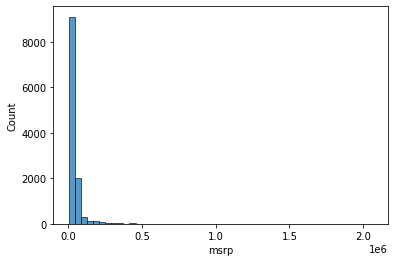

In [9]:
sns.histplot(df.msrp, bins=50)

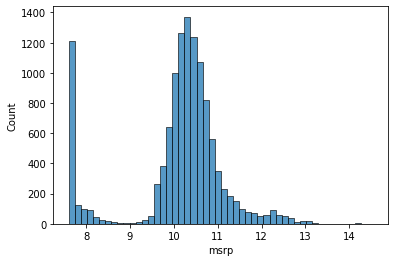

In [10]:
# change to log scale
price_logs = np.log1p(df.msrp)
sns.histplot(price_logs, bins=50)

check missing value

In [11]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

# 3. split dataset 

In [12]:
# assign 60:20:20 for training, validation and test dataset
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

df_train = df.iloc[:n_train]
df_val = df.iloc[n_train:n_train+n_val]
df_test = df.iloc[n_train+n_val:]

print(len(df_train), len(df_val), len(df_test))

7150 2382 2382


In [13]:
# shuffle dataset

idx = np.arange(n)

np.random.seed(2)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
# create target data (y, label) 
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

# create observed data (x, features)
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

#4. Writing Linear regression model

linear regression is simple weighted sum which can be written :

In [21]:
def linear_regression(xi):
    # weighted sum 
    # y = w0 + w1*x1 + .. + wd*xd 
    n = len(xi)
    pred = w0

    for j in range(n):
        pred = pred + w[j] * xi[j]

    return pred

rewrite formula even simpler with vector form, 
which requires to transform x = [1,x1,..,xd] and w = [w0,w1,..,wd]

In [22]:
def linear_regression(X):
    return X.dot(w_new)

# 5. Compute W with normal equation
In general we need to train the model with traing dataset, which means to learn weights vectors.  
In case of linear regression, we can simply comput w with normal equation

In [20]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

# 6. Build baseline model for car price prediction
## 6.1 choose feature vectors 


In [15]:
df_train.columns

Index(['make', 'model', 'year', 'engine_fuel_type', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'driven_wheels',
       'number_of_doors', 'market_category', 'vehicle_size', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'popularity'],
      dtype='object')

In [17]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

# X_train = df_train[base].fillna(0).values

def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

X_train = prepare_X(df_train)

## 6.2 learn weights

In [23]:
w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_train.dot(w)

## 6.3 evaluate with visualisation and RSME

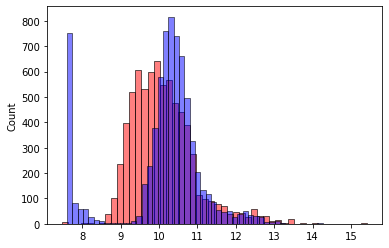

In [24]:
sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

In [25]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [26]:
rmse(y_train, y_pred)

0.7554192603920132

# 7. Improve model 
## 7.1 feature engineering 


In [28]:
# create new feature
def prepare_X(df):
    df = df.copy()
    # add age feature
    df['age'] = 2017 - df['year']
    features = base + ['age']
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values

    return X 

# train model (learn w) with new x feature vector
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

# evaluate with validation data
X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

0.5172055461058299

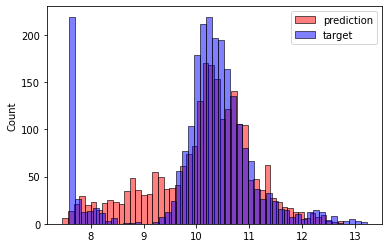

In [29]:
sns.histplot(y_pred, label='prediction', color='red', alpha=0.5, bins=50)
sns.histplot(y_val, label='target', color='blue',  alpha=0.5, bins=50)
plt.legend()

## 7.2 categorical feature

## 7.3 Regularization and hyperparameter tuning

In [ ]:
def train_linear_regression_reg(X, y, r=0.01):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [ ]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=0.01)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
rmse(y_val, y_pred)

In [ ]:
# choosing best hyperparameter lambda 

for r in [0.0, 0.00001, 0.0001, 0.001, 0.1, 1, 10]:
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print(r, w0, score)

In [ ]:
r = 0.001
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=r)

X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)
score = rmse(y_val, y_pred)
score

# 8. Using the model 

In [ ]:
# merge training and validation dataset for traing the model
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)
X_full_train = prepare_X(df_full_train)
X_full_train

y_full_train = np.concatenate([y_train, y_val])

# learn weights 
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

# evaluate with test data
X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
score = rmse(y_test, y_pred)
score

#9. check with real data 

In [ ]:
car = df_test.iloc[20].to_dict()
car

df_small = pd.DataFrame([car])
df_small

In [ ]:
X_small = prepare_X(df_small)

y_pred = w0 + X_small.dot(w)
y_pred = y_pred[0]
y_pred

np.expm1(y_pred)

In [ ]:
np.expm1(y_test[20])